In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
from tqdm.notebook import tqdm
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000

In [3]:
files = glob("../full_data_sentiment_time_lm/*.csv")
files_post = [file for file in files if "sentiment-latest_quarterly" in file]
files_pre = [file for file in files if "sentiment_quarterly" in file]

assert len(files_post) + len(files_pre) == len(files), f"length {len(files_post)} and {len(files_pre)} does not match {len(files)}"

files_pre[18]

'../full_data_sentiment_time_lm\\sentiment_subsample_twitter-roberta-base-sentiment_quarterly_data_2022_Q4.csv'

In [4]:
def get_files(file_list: list):
    data = pd.DataFrame()
    for file in tqdm(file_list):
        f_data = pd.read_csv(file, usecols=['date', 'sentiment'], error_bad_lines=False)
        data = pd.concat([data, f_data])
    
    return data
        
post_data = get_files(files_post)
pre_data = get_files(files_pre)

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

In [5]:
post_data['date'] = pd.to_datetime(post_data['date']) #format="%Y-%m-%d")
pre_data['date'] = pd.to_datetime(pre_data['date'])

In [6]:
sentiment_lbls = {"LABEL_0": -1, "LABEL_1": 0, "LABEL_2": 1}
pre_data['sentiment'] = pre_data['sentiment'].map(sentiment_lbls)

In [7]:
def smooth(data, n=1000):
    smooth_data = list()
    step_size = int(len(data) / n)
    data.sort_values(by='date', inplace=True)
    for i in range(n):
        slice = data.iloc[i*step_size: (i+1)*step_size]
        ci = 1.96 * np.std(slice['sentiment'])/np.sqrt(len(slice['date']))
        smooth_data.append({'date': slice['date'].mean(), 'sentiment': slice['sentiment'].mean(), 'ci': ci})
    
    return smooth_data

smoothness = 100
smooth_post = pd.DataFrame(smooth(post_data, smoothness))
smooth_pre = pd.DataFrame(smooth(pre_data, smoothness))

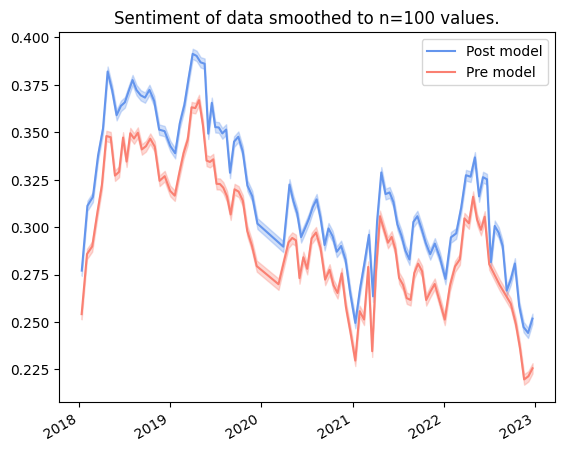

In [8]:
alpha = .3

plt.plot(smooth_post['date'], smooth_post['sentiment'], label='Post model', color='CornflowerBlue')
plt.fill_between(smooth_post['date'], (smooth_post['sentiment']-smooth_post['ci']), (smooth_post['sentiment']+smooth_post['ci']), color='CornflowerBlue', alpha=alpha)

plt.plot(smooth_pre['date'], smooth_pre['sentiment'], label="Pre model", color="salmon")
plt.fill_between(smooth_pre['date'], (smooth_pre['sentiment']-smooth_pre['ci']), (smooth_pre['sentiment']+smooth_pre['ci']), color='salmon', alpha=alpha)

plt.xticks(rotation=30, ha='right')
plt.title(f"Sentiment of data smoothed to n={smoothness} values.")
plt.legend()
plt.show()

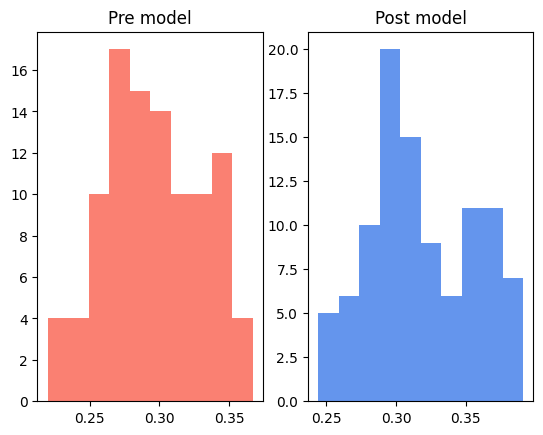

In [9]:
fig, axs = plt.subplots(1,2)

axs[0].hist(smooth_pre['sentiment'], color="salmon")
axs[0].set_title("Pre model")

axs[1].hist(smooth_post['sentiment'], color='CornflowerBlue')
axs[1].set_title("Post model")
plt.show()

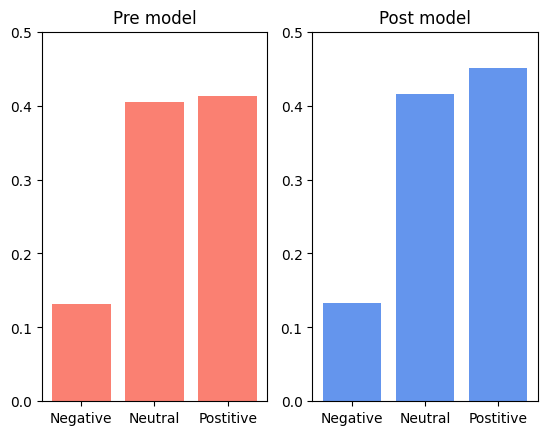

In [10]:
val_counts_post = post_data['sentiment'].value_counts()
val_counts_pre = pre_data['sentiment'].value_counts()
lbls = list(val_counts_post.keys())

fig, axs = plt.subplots(1,2)
axs[0].bar(lbls, val_counts_pre.values / len(post_data), color="salmon")
axs[0].set_title("Pre model")

axs[1].bar(lbls, val_counts_post.values / len(post_data), color='CornflowerBlue')
axs[1].set_title("Post model")

plt.setp(axs, xticks=[-1.0,0.0,1.0], xticklabels=['Negative', "Neutral", "Postitive"], yticks=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5])
plt.show()

In [20]:
get_ci = lambda x, y: 1.96 * np.std(y)/np.sqrt(x)

def smooth_count(data, n=1000):
    smooth_data = list()
    step_size = int(len(data) / n)
    data.sort_values(by='date', inplace=True)
    for i in range(n):
        slice = data.iloc[i*step_size: (i+1)*step_size]
        val_count = slice['sentiment'].value_counts(normalize=True)
        smooth_data.append(
            {
                'date': slice['date'].mean(), 
                'negative': val_count.loc[-1],
                'neutral': val_count.loc[0], 
                'positive': val_count.loc[1],
                'ci_negative': get_ci(val_count.loc[-1], slice['sentiment']),
                'ci_neutral': get_ci(val_count.loc[0], slice['sentiment']),
                'ci_positive': get_ci(val_count.loc[1], slice['sentiment']),
            }
        )
    
    return smooth_data

smoothness = 100
smooth_count_post = pd.DataFrame(smooth_count(post_data, smoothness))
smooth_count_pre = pd.DataFrame(smooth_count(pre_data, smoothness))

0     [0.12430949184006344, 3.6802040379969956]
1       [0.11455902098784346, 3.81114616567161]
2      [0.11321630365237138, 3.829986587188928]
3      [0.11405888130919446, 3.852909101571322]
4      [0.1105128459299444, 3.9087361939538607]
                        ...                    
95     [0.15039785886148382, 3.530357018529048]
96     [0.14474763222161144, 3.531845318007062]
97     [0.13952094729158593, 3.522387371097591]
98    [0.13170344871090126, 3.5659214060711037]
99     [0.12172318395227497, 3.632225171949953]
Name: negative, Length: 100, dtype: object


ValueError: setting an array element with a sequence.

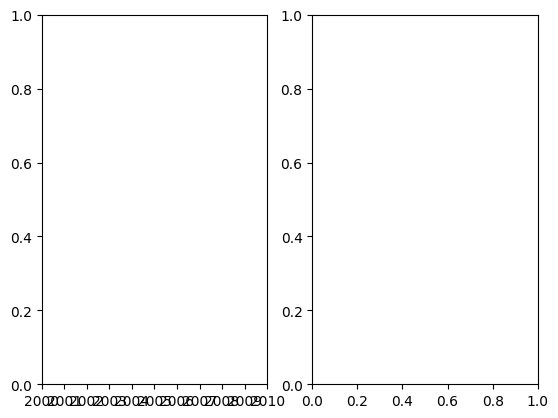

In [29]:
def create_mulitplot(data, model_labesl= ["Pre model", "Post_model"], alpha=.3):
    fig, axs = plt.subplots(1,len(data))
    cats = ['negative', 'neutral', 'positive']
    
    for i, df in enumerate(data):
        for val in cats:
            sentiment = df[val]
            ci = df[val][1]
            print(sentiment)
            axs[i].plot(df['date'], sentiment, label = val)
            axs[i].fill_between(df['date'], (sentiment-ci), (sentiment+ci), alpha=alpha)
            
        axs[0].set_title(f"{model_labesl[i]}, smoothed to n={smoothness} values")
        axs[0].legend()   
    plt.subplots_adjust(right=1.6)
    plt.show() 
        
create_mulitplot([smooth_count_pre, smooth_count_post])



# axs[0].plot(smooth_count_pre['date'], smooth_count_pre['negative'], label = "Negative")
# axs[0].plot(smooth_count_pre['date'], smooth_count_pre['neutral'] , label = "Neutral")
# axs[0].plot(smooth_count_pre['date'], smooth_count_pre['positive'], label = "Positive")
# axs[0].set_title(f"Pre model, smoothed to n={smoothness} values")
# axs[0].legend()

# axs[1].plot(smooth_count_post['date'], smooth_count_post['negative'], label="Negative")
# axs[1].plot(smooth_count_post['date'], smooth_count_post['neutral'] , label="Neutral")
# axs[1].plot(smooth_count_post['date'], smooth_count_post['positive'], label="Positive")
# axs[1].set_title(f"Post model, smoothed to n={smoothness} values")
# axs[1].legend()

# plt.subplots_adjust(right=1.6)
# plt.show()

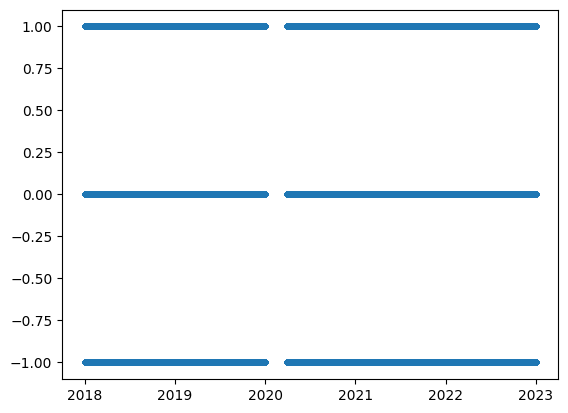

In [13]:
plt.plot(post_data['date'], post_data['sentiment'], '.')